# MNIST dataset classification

## Preliminary operations

### Import modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Download file and load data

In [ ]:
!wget https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-04-28 08:59:52--  https://s3.amazonaws.com/img-datasets/mnist.npz
Caricato certificato CA "/etc/ssl/certs/ca-certificates.crt"

Risoluzione di s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.184
Connessione a s3.amazonaws.com (s3.amazonaws.com)|52.217.229.184|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 11490434 (11M) [application/octet-stream]
Salvataggio in: «mnist.npz.3»

mnist.npz.3         100%[===================>]  10,96M   224KB/s    in 31s     

2022-04-28 09:00:24 (361 KB/s) - «mnist.npz.3» salvato [11490434/11490434]



In [ ]:
"""
The dataset is downloaded as .npz file.
When an .npz file is loaded with np.load()
the result is a dictionary-like object whose
elements are acccessible with data["label"].
The files attribute returns a list with
the possible labels.
Example:

> data = np.load("file.npz")
> print(data.files)
"""

def return_ds():
    path = "mnist.npz"

    ds = np.load(path)
    print(f"loaded dataset with labels {ds.files}\n\
Subsets are returned in the following order:\n\
x_train, x_test, y_train, y_test\n")

    return ds[ds.files[1]], ds[ds.files[0]], ds[ds.files[2]], ds[ds.files[3]]

## With PyTorch

### Import modules

In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

### Normalize data, create dataset, create dataloader

In [181]:
# Load dataset
x_train, x_test, y_train, y_test = return_ds()

print(f"Training inputs shape: {x_train.shape}")
print(f"Validation inputs shape: {x_test.shape}")
print(f"Training outputs shape: {y_train.shape}")
print(f"Validation outputs shape: {y_test.shape}")

loaded dataset with labels ['x_test', 'x_train', 'y_train', 'y_test']
Subsets are returned in the following order:
x_train, x_test, y_train, y_test

Training inputs shape: (60000, 28, 28)
Validation inputs shape: (10000, 28, 28)
Training outputs shape: (60000,)
Validation outputs shape: (10000,)


In [471]:
# Normalize and convert to tensor
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

x_train, x_test, y_train, y_test = map(
                                        torch.tensor,
                                        (x_train, x_test, y_train, y_test)
                                        )

# we need the following when converting from numpy
# otherwise pytorch will complain when training a model
torch.set_default_dtype(torch.float32)

x_train = x_train.float()
x_test = x_test.float()
y_train = y_train.long()
y_test = y_test.long()

/tmp/ipykernel_2679/745248417.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, x_test, y_train, y_test = map(


In [488]:
# Create datasets and dataloader
batch_sz = 100

cnn_train_ds = TensorDataset(x_train.unsqueeze(1), y_train)
cnn_valid_ds = TensorDataset(x_test.unsqueeze(1), y_test)
mlp_train_ds = TensorDataset(x_train.reshape(-1, 28*28), y_train)
mlp_valid_ds = TensorDataset(x_test.reshape(-1, 28*28), y_test)

cnn_train_dl = DataLoader(cnn_train_ds, batch_size=batch_sz, shuffle=True)
cnn_valid_dl = DataLoader(cnn_valid_ds, batch_size=batch_sz*4)
mlp_train_dl = DataLoader(mlp_train_ds, batch_size=batch_sz, shuffle=True)
mlp_valid_dl = DataLoader(mlp_valid_ds, batch_size=batch_sz*4)

### Define utility functions

In [671]:
# define functions for fitting model and evaluating

def step(model, xb, yb, loss_func, opt):
    loss = loss_func(model(xb), yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

    return loss


def fit(model, loss_func, train_dl, val_dl, epochs, opt):
    for epoch in range(epochs):
        model.train()
        for train_xb, train_yb in train_dl:
            loss = step(model, train_xb, train_yb, loss_func, opt)

        print(f"Training loss at epoch {epoch}: {loss:.2f}")

        model.eval()
        with torch.no_grad():
            loss = 0
            for val_xb, val_yb in val_dl:
                loss += loss_func(model(val_xb), val_yb)
            loss = loss/len(val_dl)
            print(f"Validation loss at epoch {epoch}: {loss:.2f}\n")


def eval_single_input(model, input):
    out = model(input)
    return torch.argmax(out)


def eval(model, test_x, test_y):
    n_success = 0
    for n, (x, y) in enumerate(zip(test_x, test_y)):
        out_model = eval_single_input(model, x)
        n_success += (out_model == y)

    return n_success.item()/n


### Define and train an MLP

In [672]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 20)
        self.layer2 = nn.Linear(20,15)
        self.layer3 = nn.Linear(15, 10)

    def forward(self, input):
        x = F.relu(self.layer1(input))
        x = F.relu(self.layer2(x))
        out = self.layer3(x)
        # out = F.log_softmax(self.layer3(x), dim = 1) #we use this if we choose nll_loss
        return out

In [673]:
# define a cross entropy loss (or a nll loss)

loss_func = F.cross_entropy
# loss_func = F.nll_loss

In [674]:
# instantiate a model and an optimizer

lr = 0.1

mlp_model = MLP()
optim = opt.SGD(mlp_model.parameters(), lr=lr)

In [675]:
"""
IMPORTANT
The model expects a rank-2 tensor as input, because the first dimension
corresponds to the batch size.
"""

# get a batch
xb, yb = next(iter(mlp_train_dl))

# evaluate loss for this batch
loss_func(mlp_model(xb), yb)

# compute output for a single element of the batch
# note that I need to unsqueeze to get a (1, 784) input to pass to the model
mlp_model(xb[0].unsqueeze(0))

tensor([[ 0.0711, -0.1616,  0.0938, -0.2346, -0.3482, -0.0164,  0.1668, -0.2427,
         -0.3781,  0.0947]], grad_fn=<AddmmBackward0>)

In [676]:
# fit the model
n_epochs = 10

fit(mlp_model, loss_func, mlp_train_dl, mlp_valid_dl, n_epochs, optim)

Training loss at epoch 0: 0.26
Validation loss at epoch 0: 0.26

Training loss at epoch 1: 0.14
Validation loss at epoch 1: 0.18

Training loss at epoch 2: 0.27
Validation loss at epoch 2: 0.19

Training loss at epoch 3: 0.33
Validation loss at epoch 3: 0.16

Training loss at epoch 4: 0.17
Validation loss at epoch 4: 0.15

Training loss at epoch 5: 0.24
Validation loss at epoch 5: 0.16

Training loss at epoch 6: 0.10
Validation loss at epoch 6: 0.15

Training loss at epoch 7: 0.04
Validation loss at epoch 7: 0.17

Training loss at epoch 8: 0.08
Validation loss at epoch 8: 0.15

Training loss at epoch 9: 0.15
Validation loss at epoch 9: 0.16



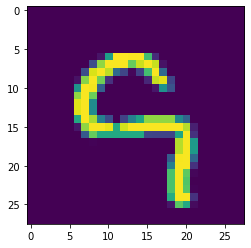

In [677]:
im = x_test[104]
plt.imshow(im)

In [678]:
print(f"This digit is a \
{eval_single_input(mlp_model, im.view(-1, 28*28)).item()} \
according to my model.")

This digit is a 9 according to my model.


In [679]:
print(f"Validation accuracy over validation set: \
{eval(mlp_model, x_test.view(-1, 784), y_test.view(-1,1))*100:.2f}%")

Validation accuracy over validation set: 95.39%


### Define and train a CNN

In [680]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=(2,2), padding_mode="circular")
        self.conv2 = nn.Conv2d(1, 1, kernel_size=2, padding=(1,1), padding_mode="circular")
        self.conv3 = nn.Conv2d(1, 1, kernel_size=2, padding=(1,1), padding_mode="circular")
        self.dense1 = nn.Linear(64, 15)
        self.dense2 = nn.Linear(15, 10)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, kernel_size=2)
        x = x.reshape(-1, 64)
        x = self.dense1(x)
        out = self.dense2(x)
        return out
        

In [681]:
# define a loss

loss_func = F.cross_entropy

In [685]:
# instantiate model and optimizer

lr = 0.1

cnn_model = CNN()
optim = opt.SGD(cnn_model.parameters(), lr=lr)

In [686]:
xb, yb = next(iter(cnn_train_dl))
sample = xb[0].unsqueeze(0)

print(f"xb has shape {xb.shape}\n")
print(f"sample from xb has shape {sample.shape}\n")

print(f"Output from a batch sample: {cnn_model(sample)}")

xb has shape torch.Size([100, 1, 28, 28])

sample from xb has shape torch.Size([1, 1, 28, 28])

Output from a batch sample: tensor([[-0.0966,  0.1666,  0.0755,  0.0756, -0.2467,  0.0174, -0.1579,  0.1931,
         -0.2599,  0.2489]], grad_fn=<AddmmBackward0>)


In [687]:
n_epochs = 10

fit(cnn_model, loss_func, cnn_train_dl, cnn_valid_dl, n_epochs, optim)

In [ ]:
x_samples = x_test.unsqueeze(1).unsqueeze(1)
y_samples = y_test.unsqueeze(1).unsqueeze(1)
print(x_samples.shape)
print(y_samples.shape)

print(f"Validation accuracy over validation set: \
{eval(cnn_model, x_samples, y_samples)*100:.2f}%")

torch.Size([10000, 1, 1, 28, 28])
torch.Size([10000, 1, 1])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 

KeyboardInterrupt: 